In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.utils import resample
from joblib import Parallel, delayed
from tqdm import tqdm


import time


# 1 Task: Make_blobs = df1

Corr Matrix:
           feature1  feature2  feature3  feature4  feature5  feature6  \
feature1   1.000000  0.988019  0.988388  0.987634  0.987854  0.988328   
feature2   0.988019  1.000000  0.988136  0.988419  0.987970  0.988087   
feature3   0.988388  0.988136  1.000000  0.988053  0.987796  0.988378   
feature4   0.987634  0.988419  0.988053  1.000000  0.987637  0.988182   
feature5   0.987854  0.987970  0.987796  0.987637  1.000000  0.988071   
feature6   0.988328  0.988087  0.988378  0.988182  0.988071  1.000000   
feature7   0.988169  0.988261  0.988081  0.987744  0.987688  0.988347   
feature8   0.987784  0.987842  0.987610  0.988226  0.987953  0.988279   
feature9   0.988147  0.988440  0.987845  0.988472  0.988026  0.988230   
feature10  0.988111  0.988167  0.988051  0.988438  0.988480  0.988299   
feature11  0.987888  0.987495  0.987608  0.987818  0.987825  0.987769   
feature12  0.987780  0.987907  0.988405  0.987933  0.987669  0.988122   
feature13  0.987767  0.987842  0.98805

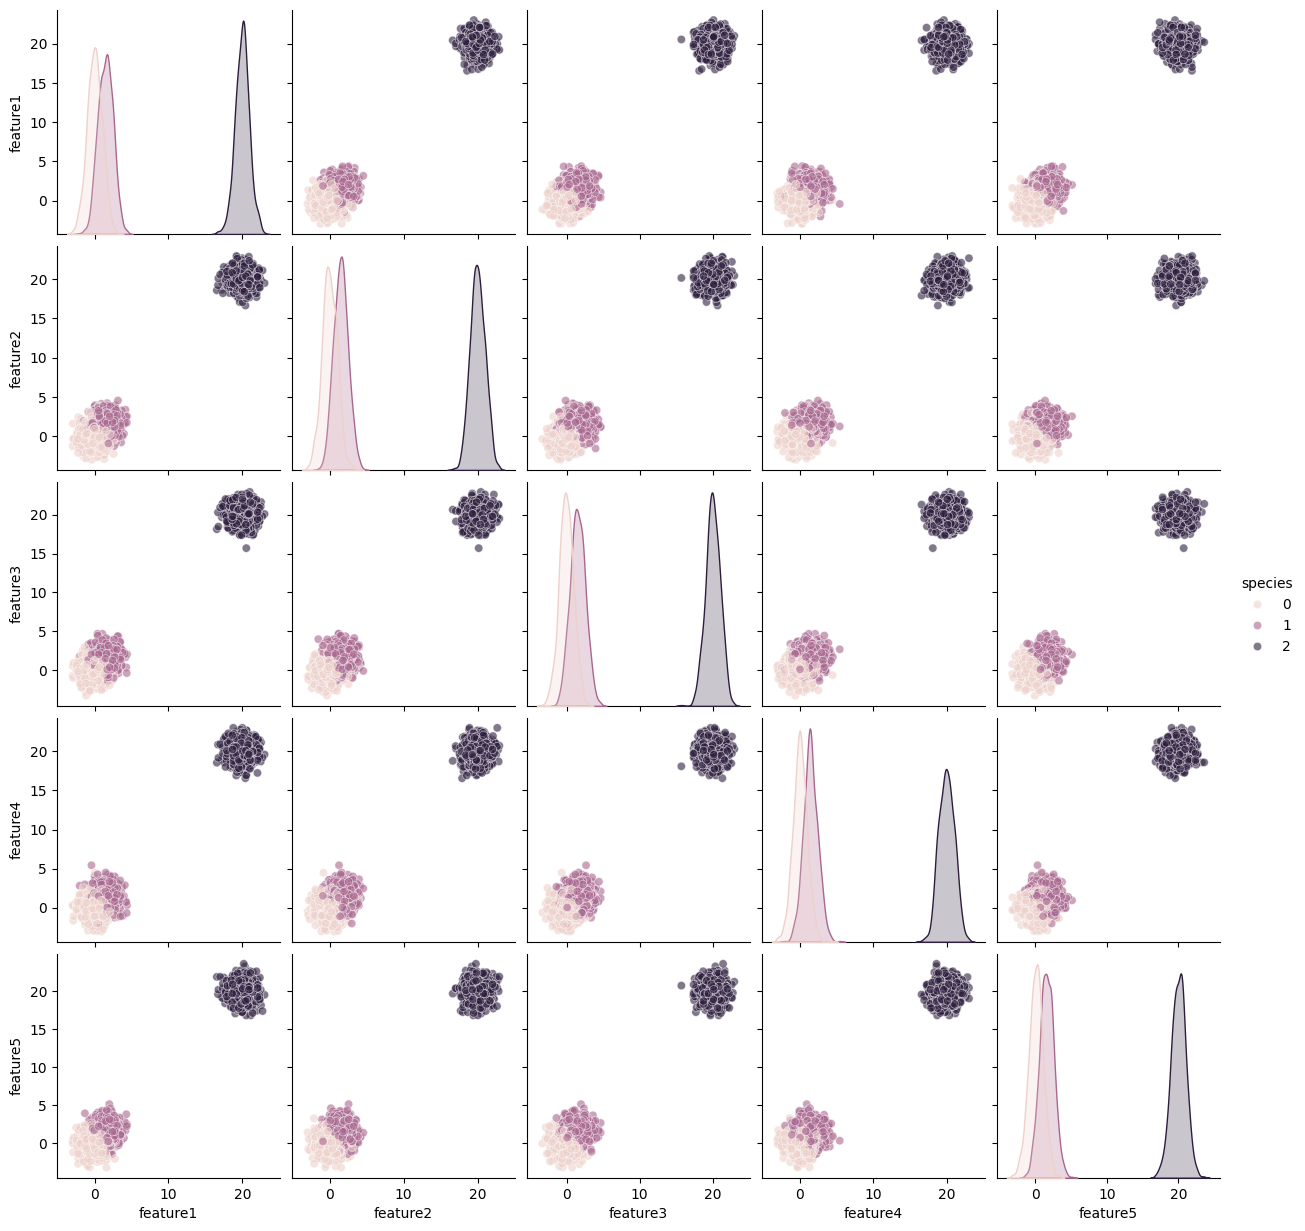

In [5]:
n_samples = 1000
n_features = 16
centers = np.array([
    np.zeros(n_features),
    np.ones(n_features) * 1.5,
    np.ones(n_features) * 20
])

x, y = make_blobs(
    n_samples=[n_samples, n_samples, n_samples],
    centers=centers,
    n_features=n_features,
    cluster_std=[1.0, 1.0, 1.0],
    random_state=42
)

feature_names = [f'feature{i+1}' for i in range(n_features)]
df1 = pd.DataFrame(x, columns=feature_names)
df1['species'] = y

corr_matrix = df1[feature_names].corr()
print('Corr Matrix:')
print(corr_matrix)

selected_features = feature_names[:5]

sns.pairplot(
    data=df1,
    vars=selected_features,
    hue='species',
    plot_kws={'alpha': 0.6},
    diag_kind='kde',
)

plt.show()



# 2 Task: Oversample DFs

In [6]:
def oversample_class(df, target_class, repeat_list, class_col='species'):
    """
    Создает несколько датасетов, где целый класс повторяется разное количество раз.
    
    Parameters:
        df: исходный DataFrame
        target_class: класс, который нужно увеличивать
        repeat_list: список множителей (например [2,5,10,...])
        class_col: название колонки с классами
    Returns:
        dict: ключи - df2, df5,..., значения - новые DataFrame
    """
    dfs = {}
    
    # Разделяем на "увеличиваемый" и остальные
    df_target = df[df[class_col] == target_class]
    df_rest = df[df[class_col] != target_class]
    
    for r in repeat_list:
        df_new = pd.concat([df_target]*r + [df_rest], ignore_index=True)
        dfs[f'df{r}'] = df_new
    
    return dfs

repeat_list = [2, 5, 10, 20, 50, 100, 1000, 10000]
target_class = 0  # например, класс 0, который пересекается с другим
oversampled_datasets = oversample_class(df1, target_class, repeat_list)

# Проверка размеров
for name, df in oversampled_datasets.items():
    print(name, df.shape)

# oversampled_datasets['df50'].head()

df2 (4000, 17)
df5 (7000, 17)
df10 (12000, 17)
df20 (22000, 17)
df50 (52000, 17)
df100 (102000, 17)
df1000 (1002000, 17)
df10000 (10002000, 17)


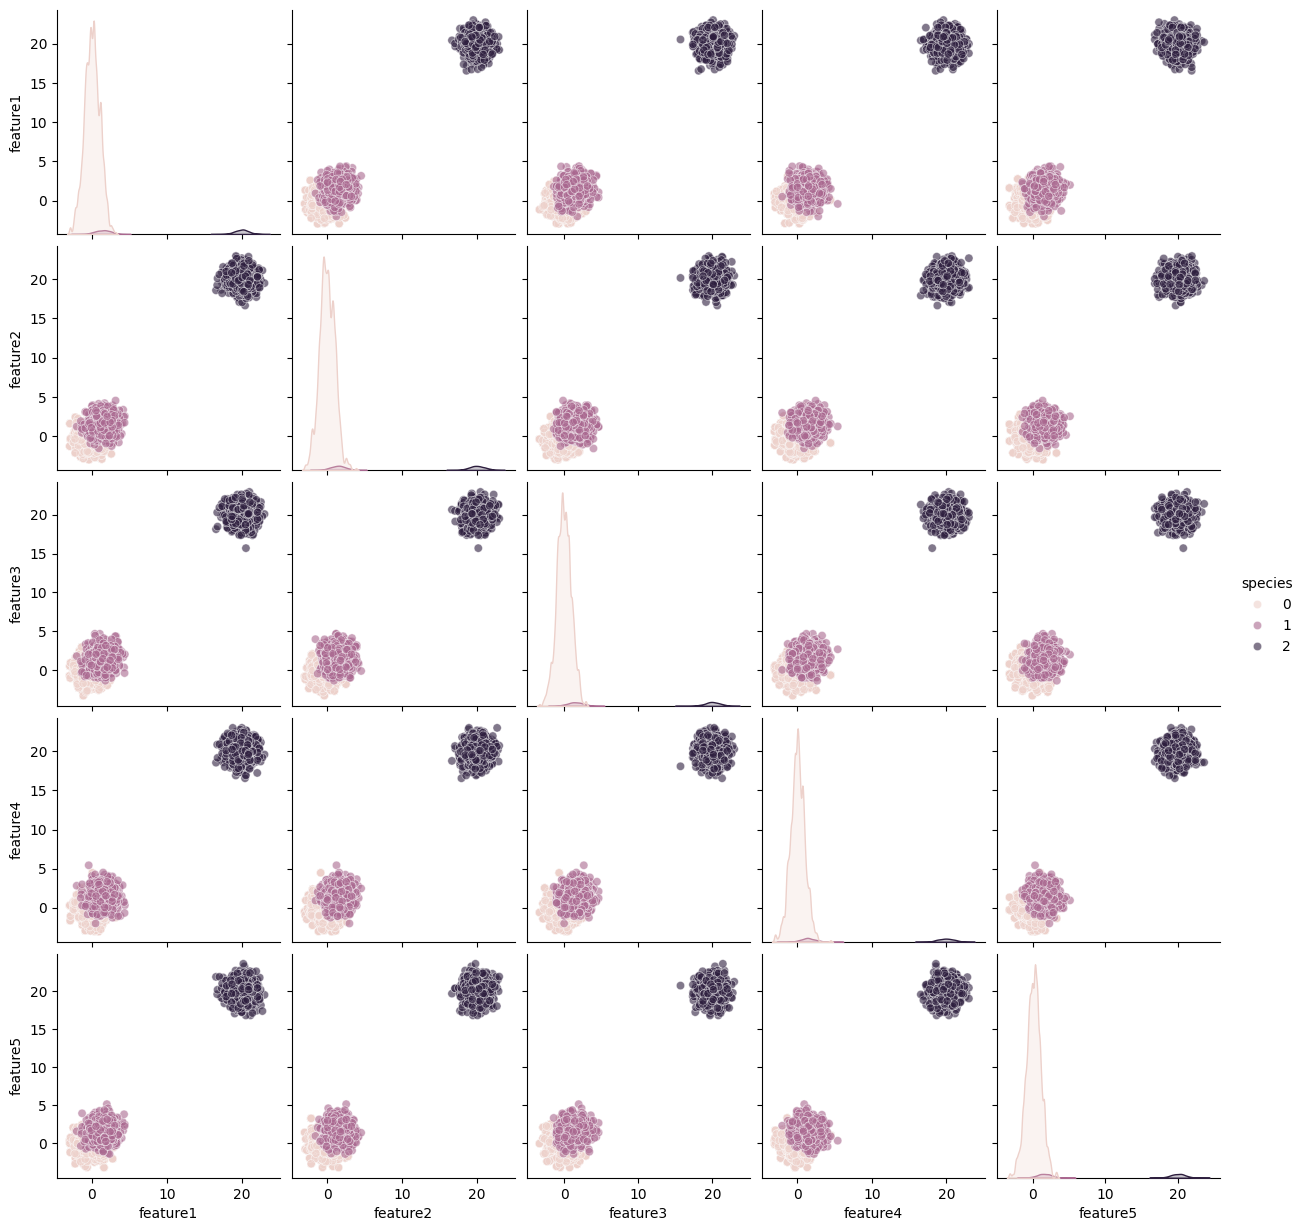

In [7]:
sns.pairplot(
    data=oversampled_datasets['df50'],
    vars=selected_features,
    hue='species',
    plot_kws={'alpha': 0.6},
    diag_kind='kde',
)

# 3-5 Task: LDA 

In [ ]:
def bootstrap_curve(y_true, scores, n_boot=1000, grid_len=200, curve_type='roc', random_state=42, n_jobs=-1):
    """
    Построение ROC или PR кривой с бутстрэпом и прогресс-баром tqdm.
    """
    rng = np.random.RandomState(random_state)
    n_samples = len(y_true)

    grid = np.linspace(0, 1, grid_len)
    tprs_boot = np.zeros((n_boot, grid_len))
    aucs_boot = np.zeros(n_boot)

    def one_boot(i):
        idx = rng.randint(0, n_samples, n_samples)
        if len(np.unique(y_true[idx])) < 2:
            return np.zeros(grid_len), np.nan
        y_b = y_true[idx]
        s_b = scores[idx]
        if curve_type == 'roc':
            fpr_b, tpr_b, _ = roc_curve(y_b, s_b)
            auc_b = auc(fpr_b, tpr_b)
            tpr_interp = np.interp(grid, fpr_b, tpr_b)
        else:
            precision_b, recall_b, _ = precision_recall_curve(y_b, s_b)
            auc_b = average_precision_score(y_b, s_b)
            tpr_interp = np.interp(grid, recall_b[::-1], precision_b[::-1])
        return tpr_interp, auc_b

    # Используем tqdm с Parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(one_boot)(i) for i in tqdm(range(n_boot), desc="Bootstrap progress")
    )

    for i, (tpr_interp, auc_b) in enumerate(results):
        tprs_boot[i, :] = tpr_interp
        aucs_boot[i] = auc_b

    valid_aucs = aucs_boot[~np.isnan(aucs_boot)]
    auc_ci = (np.nan, np.nan) if valid_aucs.size==0 else (np.percentile(valid_aucs,2.5), np.percentile(valid_aucs,97.5))
    tprs_valid = tprs_boot[~np.isnan(aucs_boot), :]
    tpr_lower = np.zeros_like(grid) if tprs_valid.size==0 else np.percentile(tprs_valid,2.5,axis=0)
    tpr_upper = np.zeros_like(grid) if tprs_valid.Вsize==0 else np.percentile(tprs_valid,97.5,axis=0)

    return {
        'grid': grid,
        'tprs_boot': tprs_boot,
        'tpr_lower': tpr_lower,
        'tpr_upper': tpr_upper,
        'auc_ci': auc_ci,
        'aucs_boot': aucs_boot
    }

def analyze_lda(
    df,
    class_pair=(0,1),
    features=('feature1', 'feature2'),
    target_class=None,
    n_boot=1000,
    fpr_grid_len=200,
    random_state=42,
    figsize=(14,6),
    show=True,
    n_jobs=-1
):
    """
    LDA анализ с визуализацией пространства, ROC и PR кривых с бутстрэп CI.

    Параметры:
        df: DataFrame с признаками и 'species'
        class_pair: кортеж классов для анализа
        features: пара признаков для визуализации
        target_class: класс для бинарной ROC/PR
        n_boot: количество бутстрэп итераций
        fpr_grid_len: сетка для интерполяции
        n_jobs: параллельные процессы для бутстрэпа
    """
    np.random.seed(random_state)
    if target_class is None:
        target_class = class_pair[0]

    df2 = df[df['species'].isin(class_pair)].copy()
    if df2.empty:
        raise ValueError("После фильтрации DataFrame пуст. Проверьте class_pair.")

    X = df2[list(features)].values
    y = df2['species'].values
    y_bin = (y == target_class).astype(int)

    lda = LinearDiscriminantAnalysis()
    t0 = time.time()
    lda.fit(X, y_bin)
    lda_time = time.time() - t0

    # Решающее поле
    x_min, x_max = X[:,0].min() - 1.0, X[:,0].max() + 1.0
    y_min, y_max = X[:,1].min() - 1.0, X[:,1].max() + 1.0
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400), np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    try:
        Z = lda.decision_function(grid)
    except:
        Z = lda.predict_proba(grid)[:,1]
    Z = Z.reshape(xx.shape)

    # Центры классов
    centers = {}
    for cls in class_pair:
        Xc = df2[df2['species']==cls][list(features)].values
        centers[f'class_{cls}'] = Xc.mean(axis=0)
    centers['global_center'] = np.vstack([centers[f'class_{c}'] for c in class_pair]).mean(axis=0)
    centers['segment_mid'] = (centers[f'class_{class_pair[0]}'] + centers[f'class_{class_pair[1]}']) / 2.0

    # Scores для ROC/PR
    try:
        scores = lda.decision_function(X)
    except:
        scores = lda.predict_proba(X)[:,1]

    roc_result = bootstrap_curve(y_bin, scores, n_boot=n_boot, grid_len=fpr_grid_len, curve_type='roc', random_state=random_state, n_jobs=n_jobs)
    pr_result = bootstrap_curve(y_bin, scores, n_boot=n_boot, grid_len=fpr_grid_len, curve_type='pr', random_state=random_state, n_jobs=n_jobs)

    # Визуализация
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    ax0, ax1 = axes

    # Левая: LDA пространство
    ax0.contourf(xx, yy, Z > 0, levels=[-1,0,1], colors=["#f86969","#8bff8b"], alpha=0.3) 
    ax0.contour(xx, yy, Z, levels=[0], linewidths=2, linestyles='--', colors='black')  # решающая линия
    colors = {class_pair[0]:'C0', class_pair[1]:'C1'}

    for cls in class_pair:
        sel = df2['species']==cls
        color = 'green' if cls == target_class else 'red'
        ax0.scatter(df2.loc[sel, features[0]], df2.loc[sel, features[1]],
                    s=30, alpha=0.7, label=f'class {cls}', color=color)
    # центры и линия
    c0, c1 = centers[f'class_{class_pair[0]}'], centers[f'class_{class_pair[1]}']
    ax0.scatter([c0[0]], [c0[1]], s=120, marker='X', edgecolor='k', linewidth=1.2)
    ax0.scatter([c1[0]], [c1[1]], s=120, marker='X', edgecolor='k', linewidth=1.2)
    ax0.plot([c0[0], c1[0]], [c0[1], c1[1]], linestyle='-', linewidth=2, alpha=0.7)
    mid = (c0+c1)/2
    ax0.scatter([mid[0]], [mid[1]], s=80, marker='o', facecolors='none', edgecolor='k')

    ax0.set_xlabel(features[0])
    ax0.set_ylabel(features[1])
    ax0.set_title('LDA decision regions + data')
    ax0.legend()
    ax0.grid(True, alpha=0.2)
    ax0.text(0.01, 0.99, f'LDA fit time: {lda_time:.4f} s', transform=ax0.transAxes,
             verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    # Правая: ROC + PR кривые
    ax1.plot(roc_result['grid'], roc_result['tprs_boot'].mean(axis=0), lw=2, label=f'ROC mean AUC = {roc_result["aucs_boot"].mean():.3f}')
    ax1.fill_between(roc_result['grid'], roc_result['tpr_lower'], roc_result['tpr_upper'], alpha=0.25, label='ROC 95% CI')
    ax1.plot(pr_result['grid'], pr_result['tprs_boot'].mean(axis=0), lw=2, color='orange', label=f'PR mean AUPRC = {pr_result["aucs_boot"].mean():.3f}')
    ax1.fill_between(pr_result['grid'], pr_result['tpr_lower'], pr_result['tpr_upper'], alpha=0.15, color='orange', label='PR 95% CI')
    ax1.plot([0,1],[0,1], linestyle='--', color='grey', linewidth=1)
    ax1.set_xlabel('FPR / Recall')
    ax1.set_ylabel('TPR / Precision')
    ax1.set_title(f'ROC & PR curves (target class = {target_class})')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.2)

    if show:
        plt.tight_layout()
        plt.show()

    return {
        'fig': fig,
        'lda_time': lda_time,
        'centers': centers,
        'roc_result': roc_result,
        'pr_result': pr_result
    }


=== Анализ для df2 ===


Bootstrap progress:   0%|          | 0/1500 [00:00<?, ?it/s]

Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 9241.26it/s]


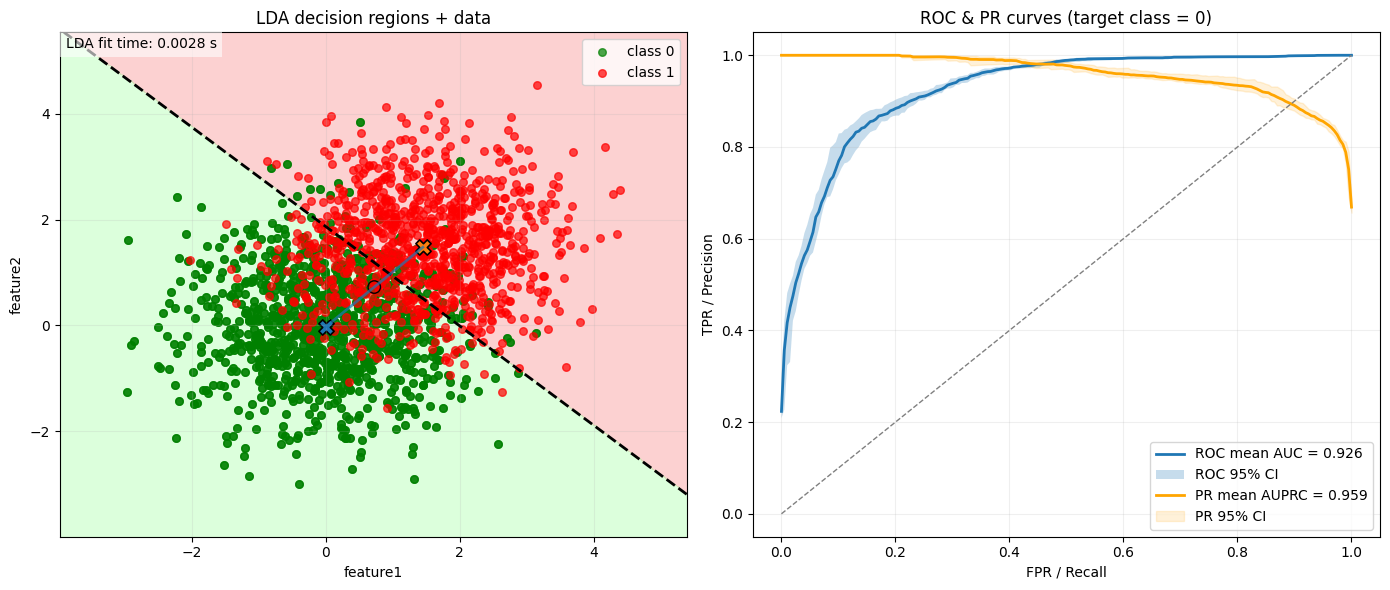

ROC AUC = 0.926, CI95 = [0.921, 0.933]
PR AUPRC = 0.959, CI95 = [0.957, 0.966]

=== Анализ для df5 ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 7279.93it/s]


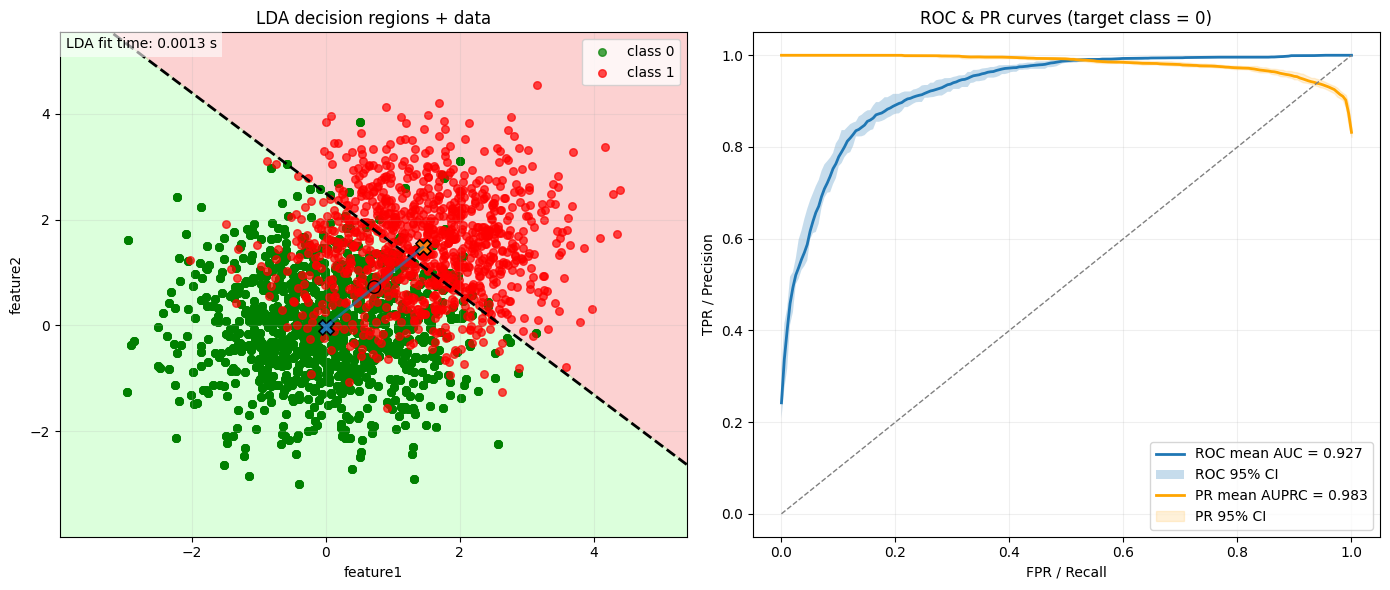

ROC AUC = 0.927, CI95 = [0.918, 0.937]
PR AUPRC = 0.983, CI95 = [0.981, 0.986]

=== Анализ для df10 ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 6264.51it/s]


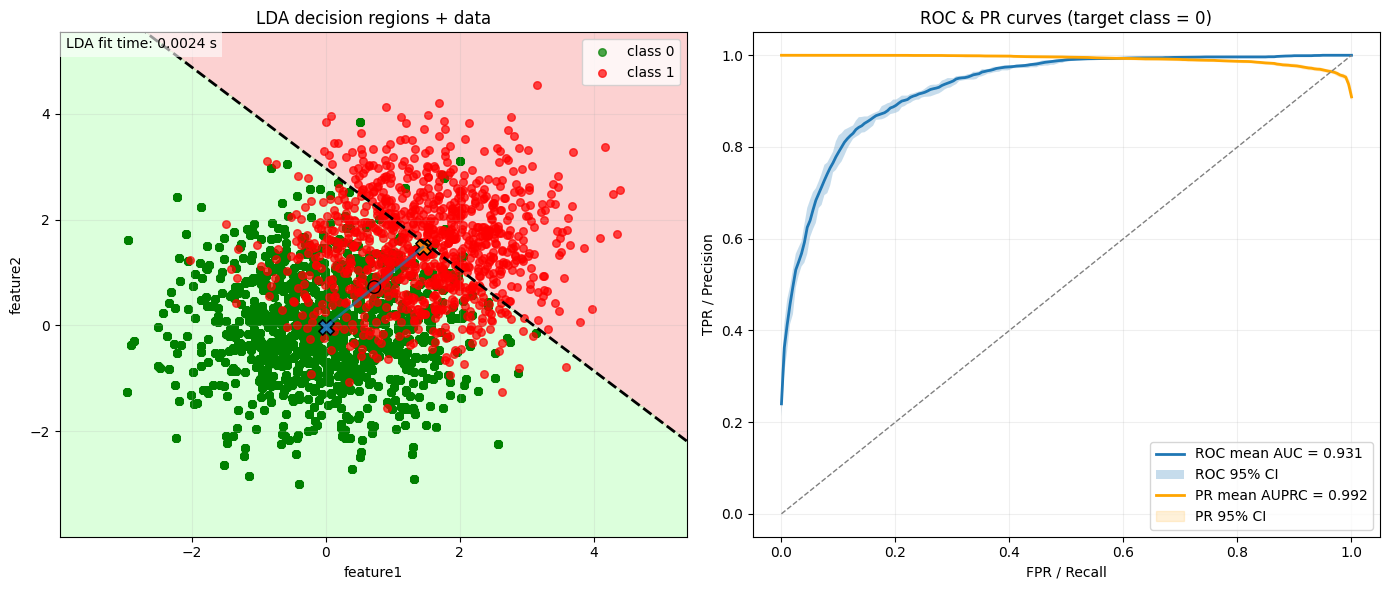

ROC AUC = 0.931, CI95 = [0.924, 0.935]
PR AUPRC = 0.992, CI95 = [0.991, 0.993]

=== Анализ для df20 ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 4660.11it/s]


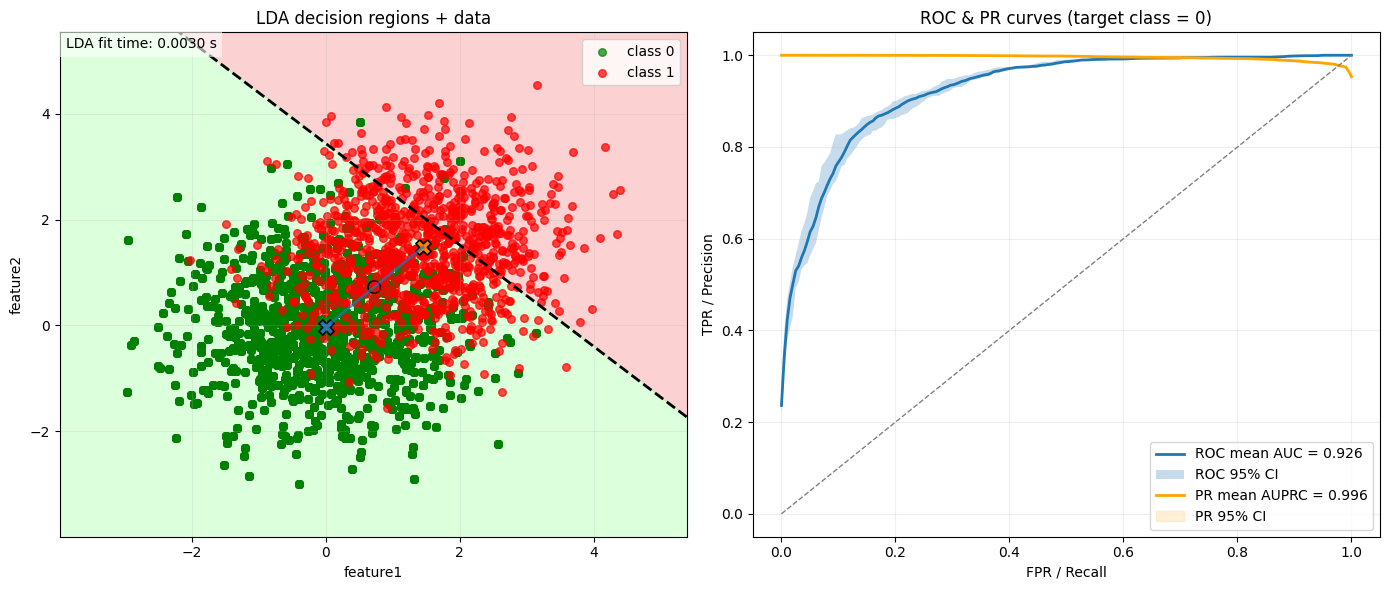

ROC AUC = 0.926, CI95 = [0.919, 0.934]
PR AUPRC = 0.996, CI95 = [0.995, 0.996]

=== Анализ для df50 ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 1754.84it/s]


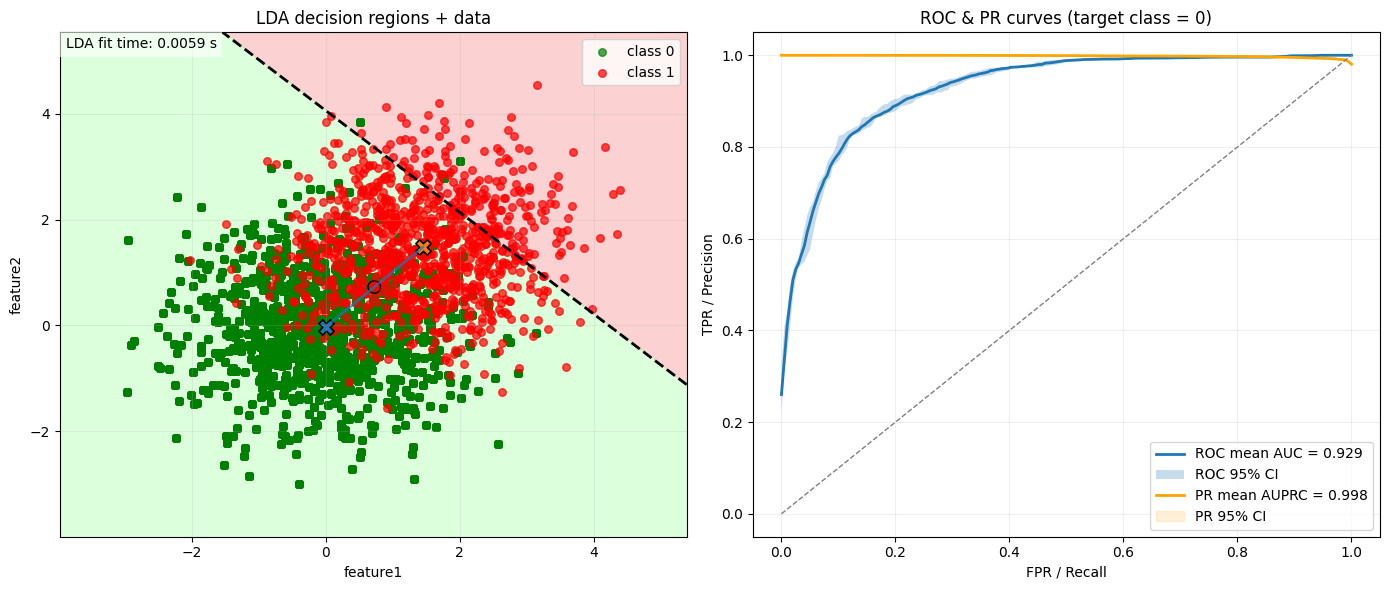

ROC AUC = 0.929, CI95 = [0.925, 0.934]
PR AUPRC = 0.998, CI95 = [0.998, 0.999]

=== Анализ для df100 ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:02<00:00, 635.32it/s]


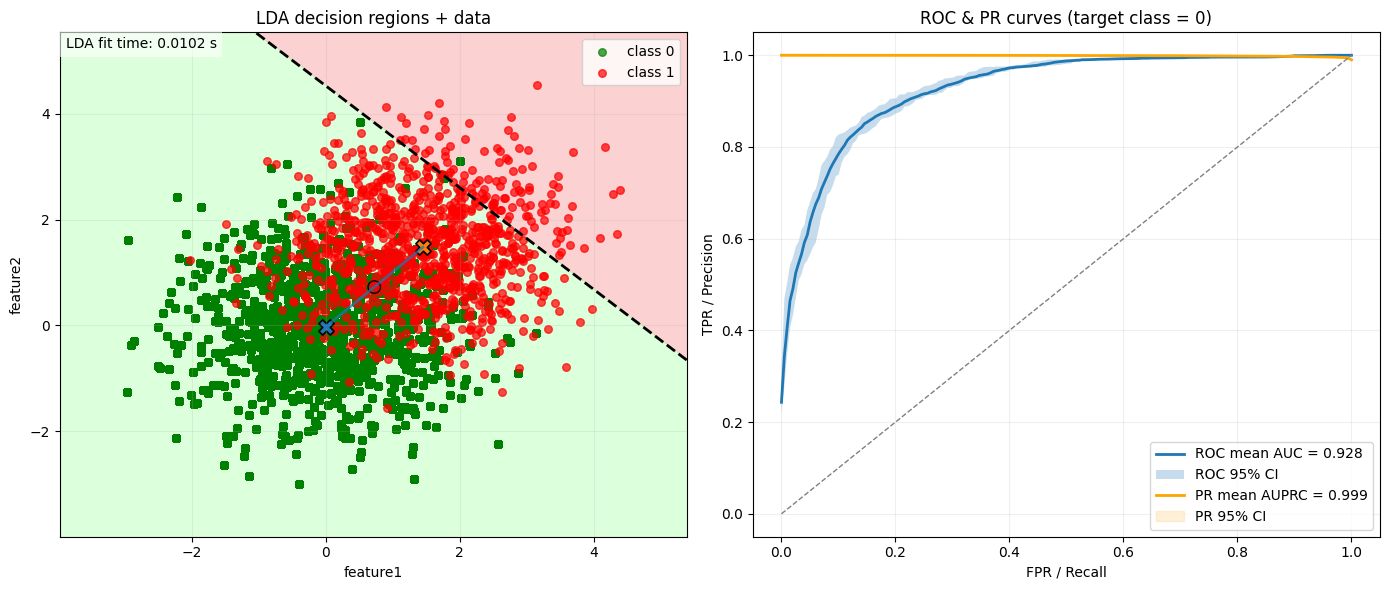

ROC AUC = 0.928, CI95 = [0.921, 0.937]
PR AUPRC = 0.999, CI95 = [0.999, 0.999]

=== Анализ для df1000 ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:34<00:00, 43.52it/s]


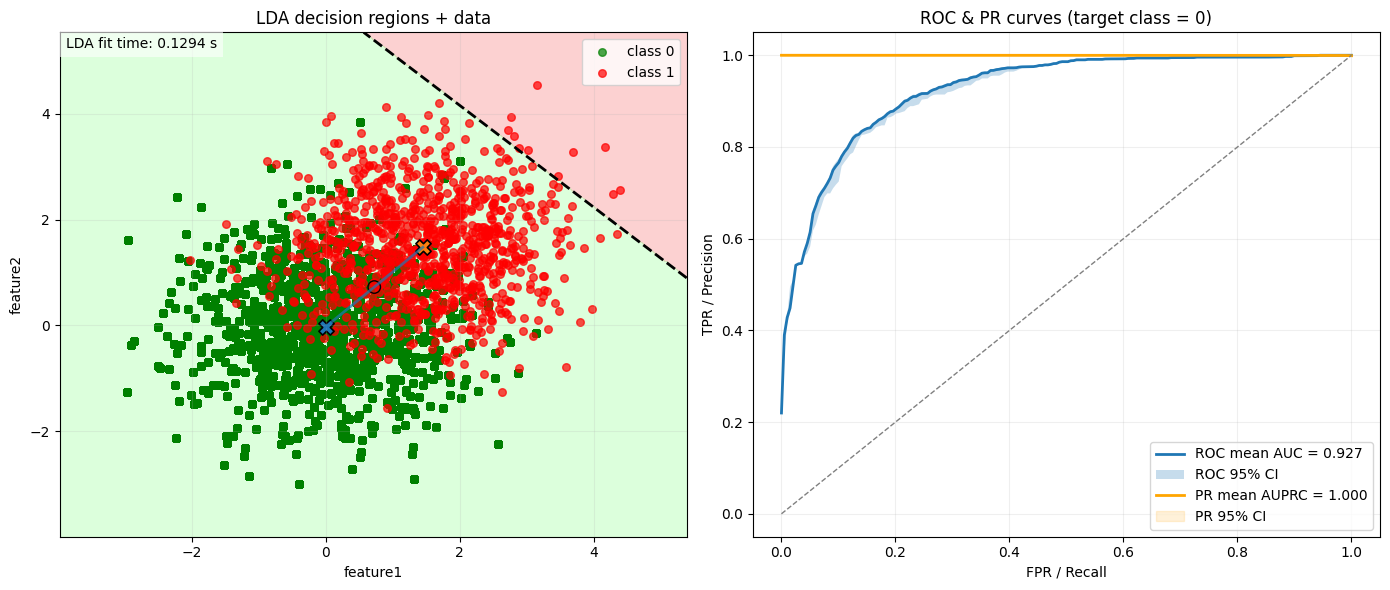

ROC AUC = 0.927, CI95 = [0.920, 0.928]
PR AUPRC = 1.000, CI95 = [1.000, 1.000]

=== Анализ для df10000 ===


Bootstrap progress: 100%|██████████| 1500/1500 [09:41<00:00,  2.58it/s]
/tmp/ipykernel_14365/1965327058.py:164: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/toasty/repos/tsd/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


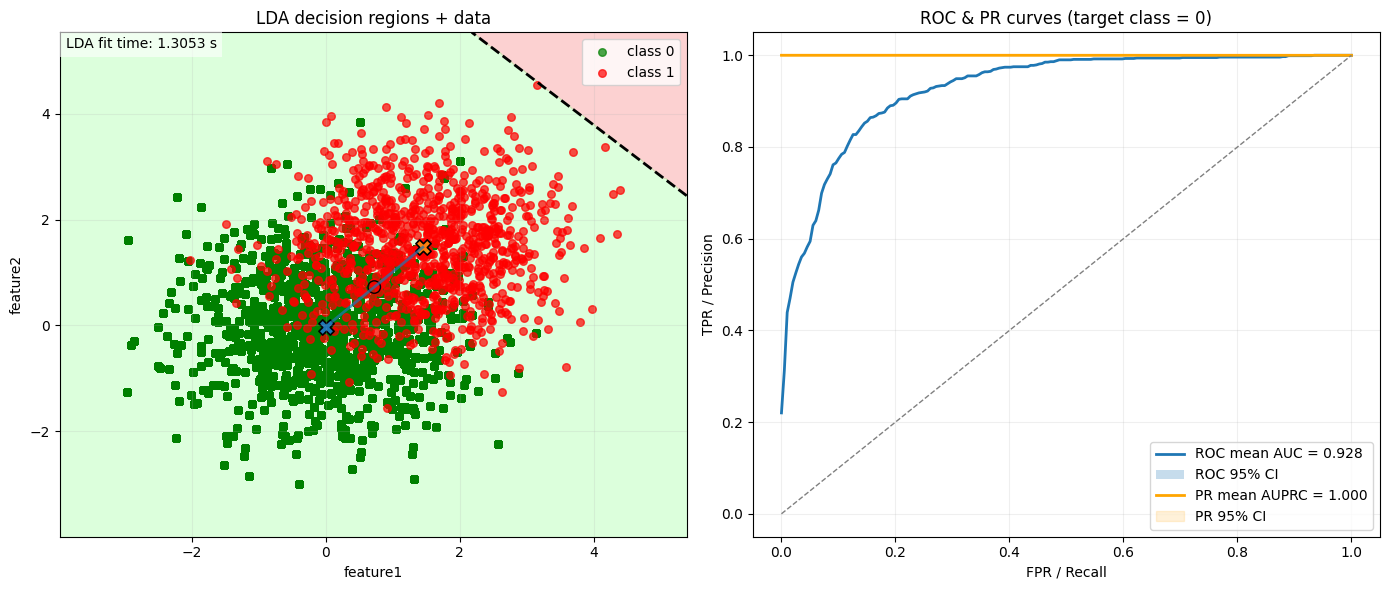

ROC AUC = 0.928, CI95 = [0.928, 0.928]
PR AUPRC = 1.000, CI95 = [1.000, 1.000]


In [9]:
for name, dfN in oversampled_datasets.items():
    print(f"\n=== Анализ для {name} ===")
    result = analyze_lda(
        df=dfN,
        class_pair=(0, 1),
        features=('feature1', 'feature2'),
        target_class=0,
        n_boot=1500,        # при очень больших df можно поставить меньше, например 500
        show=True,
        n_jobs=-1           # параллельный бутстрэп
    )
    
    # Численные результаты
    roc_auc_mean = np.mean(result['roc_result']['aucs_boot'])
    roc_ci = result['roc_result']['auc_ci']
    pr_auc_mean = np.mean(result['pr_result']['aucs_boot'])
    pr_ci = result['pr_result']['auc_ci']
    
    print(f"ROC AUC = {roc_auc_mean:.3f}, CI95 = [{roc_ci[0]:.3f}, {roc_ci[1]:.3f}]")
    print(f"PR AUPRC = {pr_auc_mean:.3f}, CI95 = [{pr_ci[0]:.3f}, {pr_ci[1]:.3f}]")



=== Анализ для df2 (target_class = 1) ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 8998.77it/s]


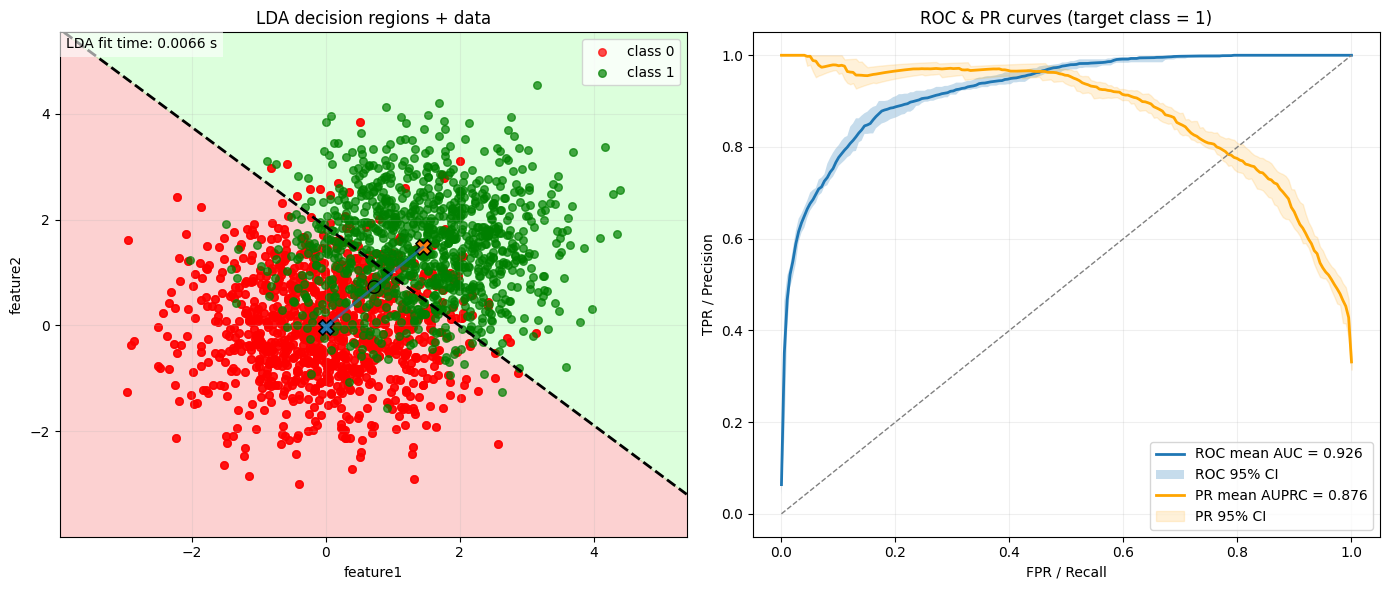


=== Анализ для df5 (target_class = 1) ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 7751.54it/s]


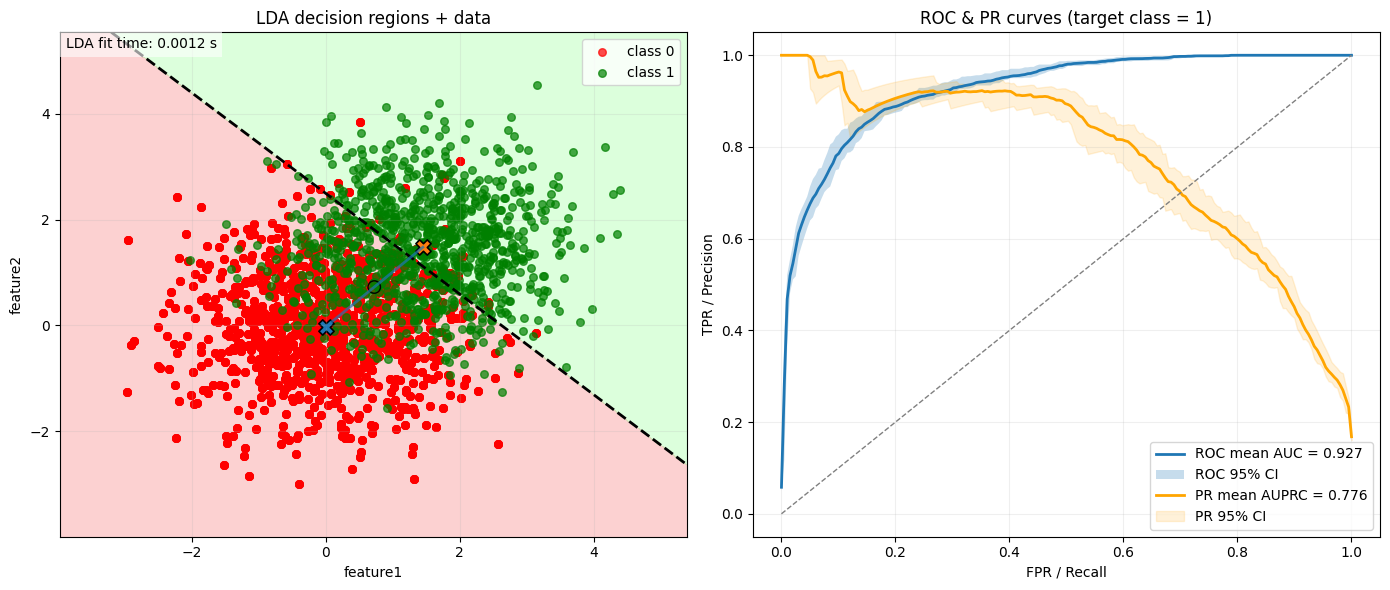


=== Анализ для df10 (target_class = 1) ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 5772.72it/s]


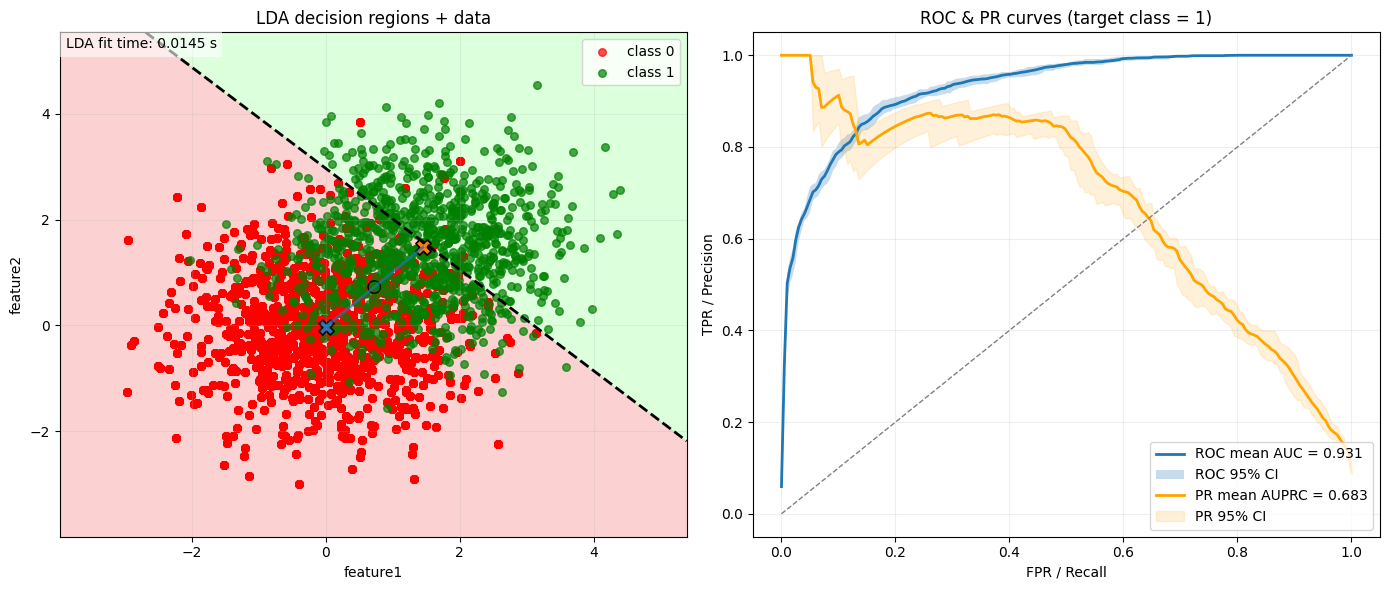


=== Анализ для df20 (target_class = 1) ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 4287.24it/s]


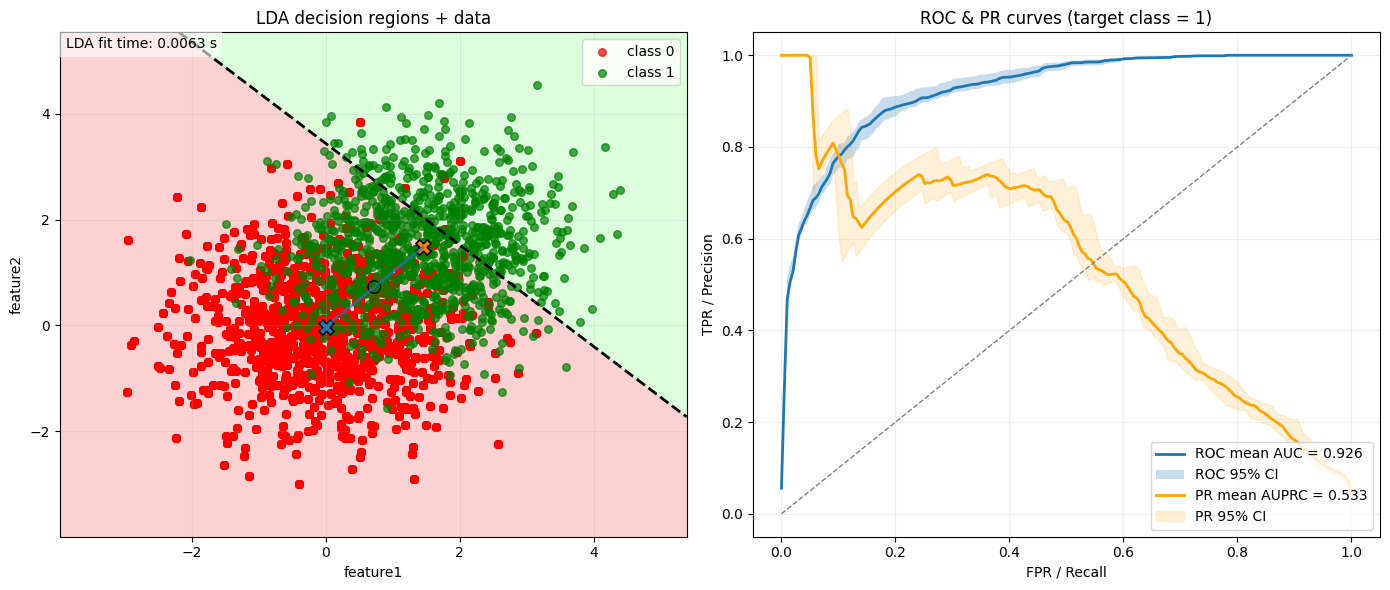


=== Анализ для df50 (target_class = 1) ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, -19337.62it/s]


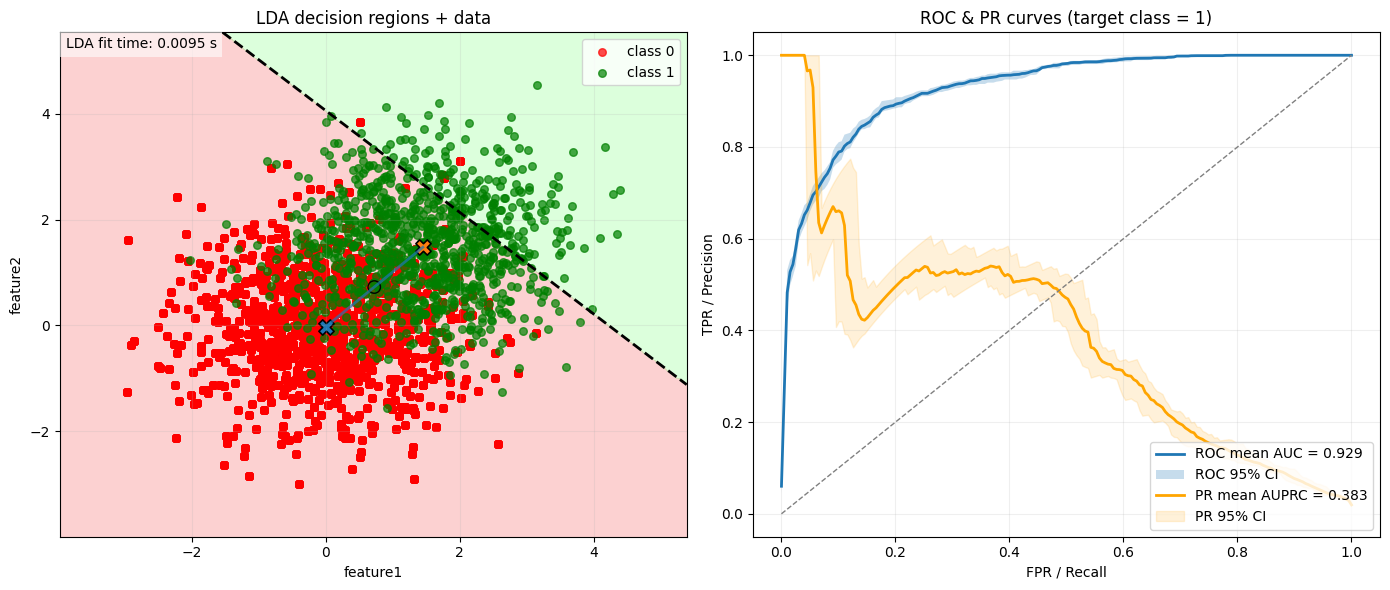


=== Анализ для df100 (target_class = 1) ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:02<00:00, 514.12it/s]


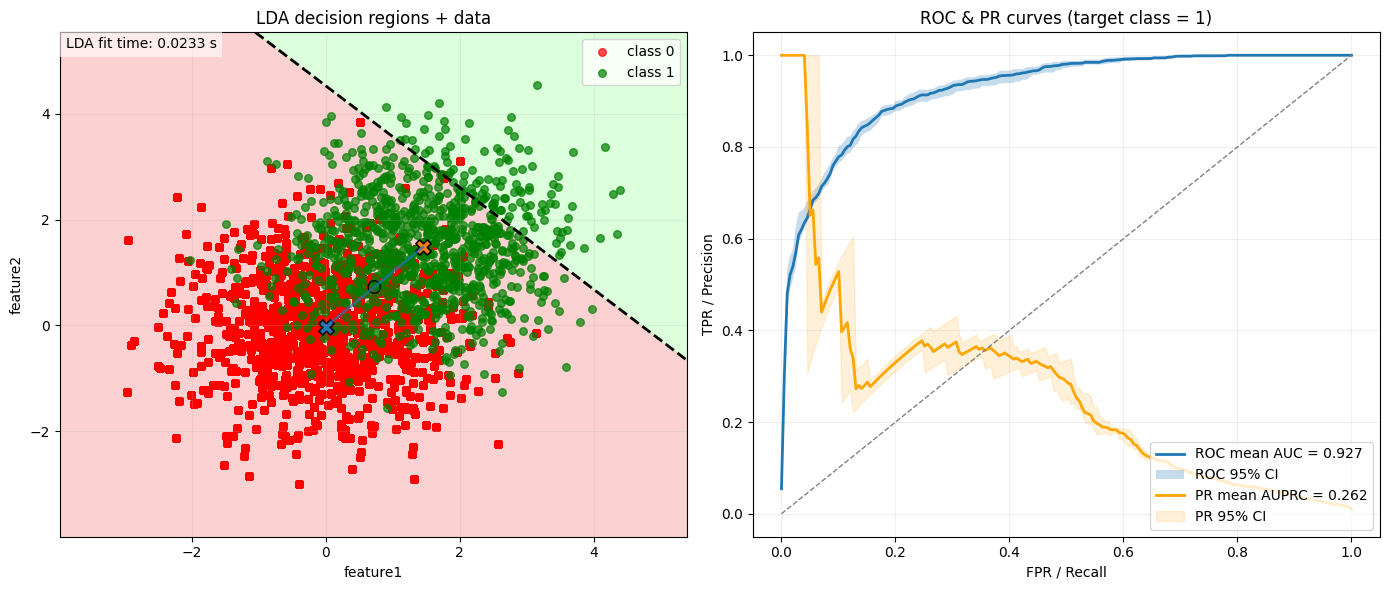


=== Анализ для df1000 (target_class = 1) ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:39<00:00, 38.35it/s]


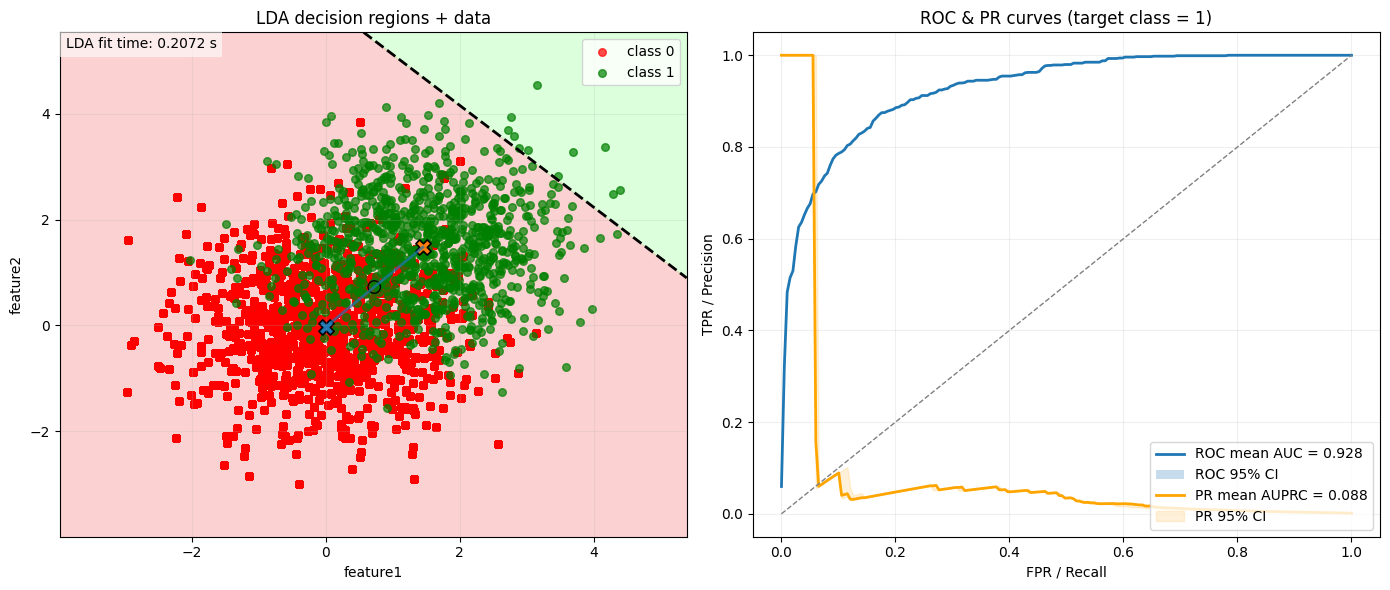


=== Анализ для df10000 (target_class = 1) ===


Bootstrap progress: 100%|██████████| 1500/1500 [10:44<00:00,  2.33it/s]
/tmp/ipykernel_14365/1965327058.py:164: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/toasty/repos/tsd/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


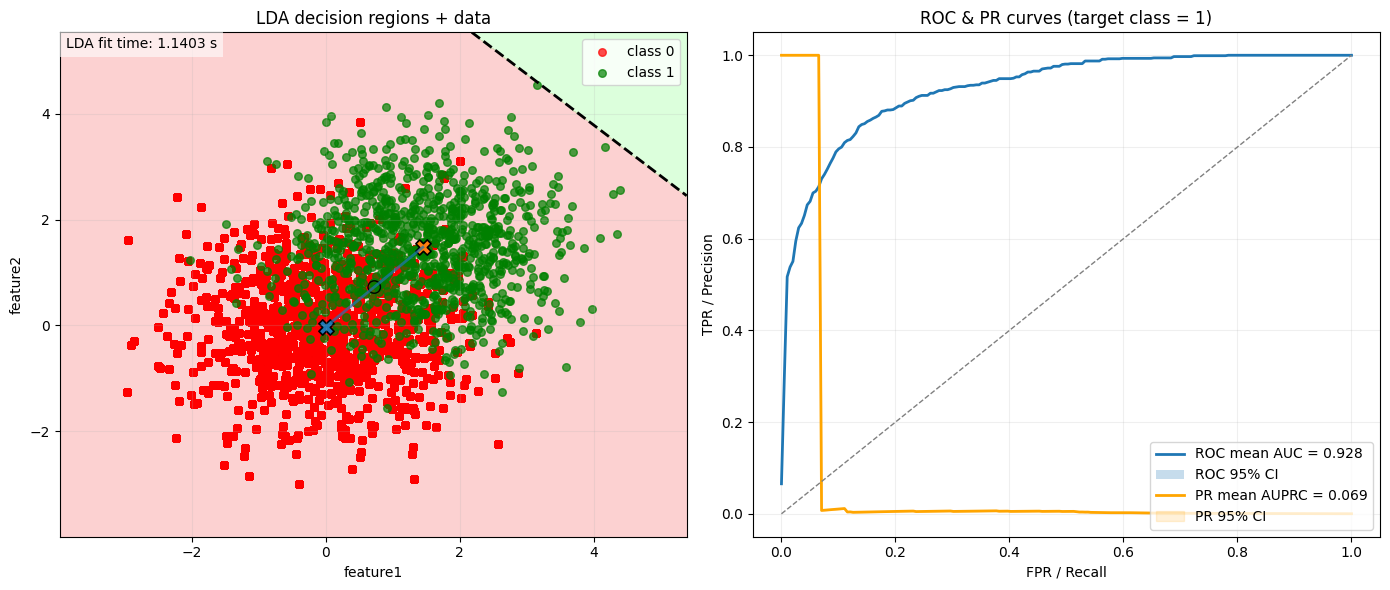

In [18]:
for name, dfN in oversampled_datasets.items():
    print(f"\n=== Анализ для {name} (target_class = 1) ===")
    analyze_lda(
        df=dfN,
        class_pair=(0, 1),
        features=('feature1', 'feature2'),
        target_class=1,  # <- новый целевой класс
        n_boot=1500,
        show=True,
        n_jobs=-1
    )
